### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from datetime import datetime, date
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_log_error, make_scorer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor
%matplotlib inline
pd.pandas.set_option('display.max_columns', None)

###  Reading Data Sets

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### Train Data

In [3]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1


### Test Data

In [4]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered
0,2012-06-30 1:00:00,3,0,0,3,26.24,28.790,89.0,15.0013,3,55
1,2012-06-30 2:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,7,54
2,2012-06-30 3:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,3,20
3,2012-06-30 4:00:00,3,0,0,2,25.42,27.275,94.0,0.0000,3,15
4,2012-06-30 5:00:00,3,0,0,1,26.24,28.790,89.0,11.0014,3,7


### Shape of Train and Test Data

In [5]:
df_train.shape, df_test.shape

((12980, 12), (4399, 11))

### Data Types of Train and Test Data

In [6]:
data_types_train = pd.DataFrame(df_train.dtypes, columns = ['Train'])
data_types_test = pd.DataFrame(df_test.dtypes, columns = ['Test'])
data_types = pd.concat([data_types_train, data_types_test], axis = 1)
data_types

,Train,Test
datetime,object,object
season,int64,int64
holiday,int64,int64
workingday,int64,int64
weather,int64,int64
temp,float64,float64
atemp,float64,float64
humidity,float64,float64
windspeed,float64,float64
casual,int64,int64


### Missing Values in Train and Test Data

In [7]:
missing_values_train = pd.DataFrame(df_train.isna().sum(), columns = ['Train'])
missing_values_test = pd.DataFrame(df_test.isna().sum(), columns = ['Test'])
missing_values = pd.concat([missing_values_train, missing_values_test], axis = 1)
missing_values

,Train,Test
datetime,0,0.0
season,0,0.0
holiday,0,0.0
workingday,0,0.0
weather,0,0.0
temp,0,0.0
atemp,0,0.0
humidity,0,0.0
windspeed,0,0.0
casual,0,0.0


### Extracting Information from Datetime Column and Dropping It

In [8]:
df_train['yyyymmdd'] = df_train['datetime'].apply(lambda x : x.split()[0])
df_train['year'] = df_train['yyyymmdd'].apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d').year)
df_train['month'] = df_train['yyyymmdd'].apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d').month)
df_train['date'] = df_train['yyyymmdd'].apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d').day)
df_train['hour'] = df_train['datetime'].apply(lambda x : x.split()[1].split(":")[0])
df_train = df_train.drop(['datetime', 'yyyymmdd'], axis = 1)

In [9]:
df_test['yyyymmdd'] = df_test['datetime'].apply(lambda x : x.split()[0])
df_test['year'] = df_test['yyyymmdd'].apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d').year)
df_test['month'] = df_test['yyyymmdd'].apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d').month)
df_test['date'] = df_test['yyyymmdd'].apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d').day)
df_test['hour'] = df_test['datetime'].apply(lambda x : x.split()[1].split(":")[0])
df_test = df_test.drop(['datetime', 'yyyymmdd'], axis = 1)

### Categorizing Date Column Into Week and Dropping It

In [10]:
week = []
for i in df_train['date']:
    if i < 8:
        week.append(1)
    elif i >= 8 and i < 16:
        week.append(2)
    elif i >=16 and i < 22:
        week.append(3)
    else:
        week.append(4)
df_train['week'] = week
df_train = df_train.drop('date', axis = 1)

In [11]:
week = []
for i in df_test['date']:
    if i < 8:
        week.append(1)
    elif i >= 8 and i < 16:
        week.append(2)
    elif i >=16 and i < 22:
        week.append(3)
    else:
        week.append(4)
df_test['week'] = week
df_test = df_test.drop('date', axis = 1)

### Converting Hour Column to Int Type

In [12]:
df_train['hour'] = df_train['hour'].astype('object').astype(int)
df_test['hour'] = df_test['hour'].astype('object').astype(int)

### Columns of Train and Test Data

In [13]:
df_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'year',
       'month', 'hour', 'week'],
      dtype='object')

In [14]:
df_test.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'year', 'month',
       'hour', 'week'],
      dtype='object')

### Data Types of Train and Test Data

In [15]:
data_types_train = pd.DataFrame(df_train.dtypes, columns = ['Train'])
data_types_test = pd.DataFrame(df_test.dtypes, columns = ['Test'])
data_types = pd.concat([data_types_train, data_types_test], axis = 1)
data_types

,Train,Test
season,int64,int64
holiday,int64,int64
workingday,int64,int64
weather,int64,int64
temp,float64,float64
atemp,float64,float64
humidity,float64,float64
windspeed,float64,float64
casual,int64,int64
registered,int64,int64


### Train Data

In [16]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,week
0,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16,2011,1,0,1
1,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32,2011,1,2,1
3,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13,2011,1,3,1
4,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1,2011,1,4,1


### Test Data

In [17]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,year,month,hour,week
0,3,0,0,3,26.24,28.790,89.0,15.0013,3,55,2012,6,1,4
1,3,0,0,2,26.24,28.790,89.0,0.0000,7,54,2012,6,2,4
2,3,0,0,2,26.24,28.790,89.0,0.0000,3,20,2012,6,3,4
3,3,0,0,2,25.42,27.275,94.0,0.0000,3,15,2012,6,4,4
4,3,0,0,1,26.24,28.790,89.0,11.0014,3,7,2012,6,5,4


### Numerical Analysis of Train Data Continuous Variables

In [18]:
df_train[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000
mean,19.725422,23.112436,62.358552,13.141760,32.441757,135.136055,167.577812
std,7.828902,8.552046,19.963696,8.325987,46.636228,131.921431,160.758887
min,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.120000,15.910000,47.000000,7.001500,3.000000,30.000000,35.000000
50%,19.680000,23.485000,62.000000,12.998000,14.000000,103.000000,124.000000
75%,26.240000,30.305000,79.000000,19.001200,42.000000,194.000000,245.000000
max,40.180000,50.000000,100.000000,56.996900,367.000000,796.000000,957.000000


### Numerical Analysis of Test Data Continuous Variables

In [19]:
df_test[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']].describe()

,temp,atemp,humidity,windspeed,casual,registered
count,4399.000000,4399.000000,4399.000000,4399.000000,4399.000000,4399.000000
mean,22.297513,25.784351,63.797909,11.540867,45.220050,208.819277
std,7.775455,8.400126,17.118806,7.680410,55.364112,187.367255
min,5.740000,7.575000,16.000000,0.000000,0.000000,0.000000
25%,14.760000,18.180000,50.000000,7.001500,6.000000,49.000000
50%,22.960000,26.515000,65.000000,11.001400,25.000000,171.000000
75%,28.700000,32.575000,78.000000,16.997900,67.000000,303.000000
max,41.000000,45.455000,100.000000,43.998900,362.000000,886.000000


### Train Data Correlation

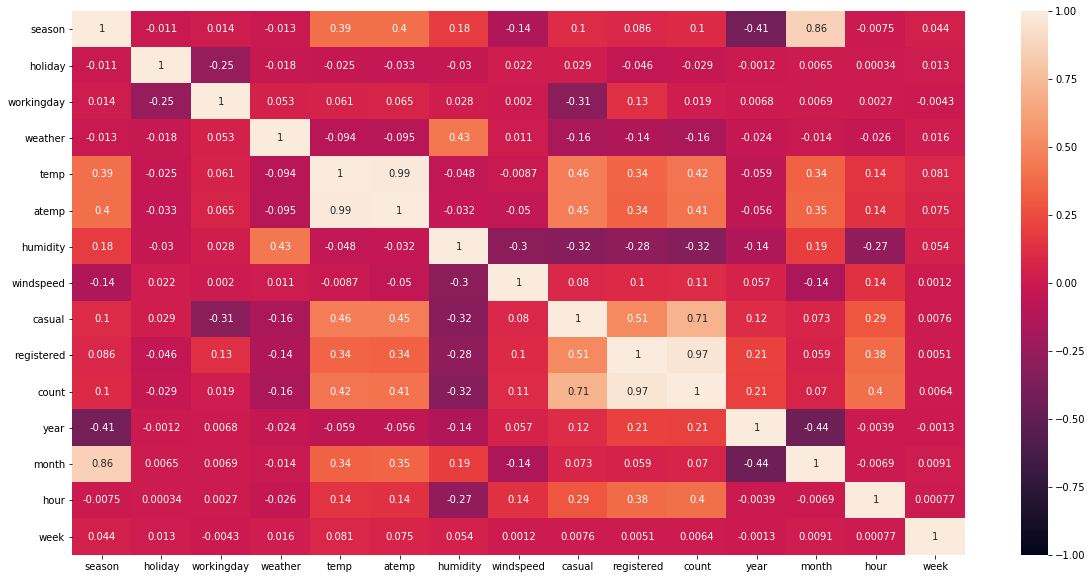

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(df_train.corr(), vmax = 1, vmin = -1, square = False, annot = True)

        Count is very highly positively related to registered and casual.

        Season is very highly positively related to month.

        Temperature is very highly positively related to Actual Temperature

### Relation Between Season and Count

Text(0, 0.5, 'Count')

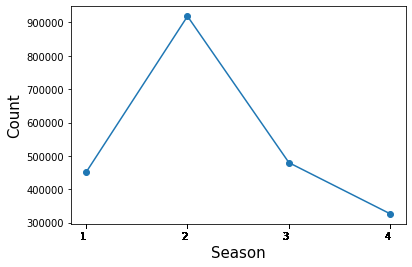

In [23]:
df_train.groupby('season')['count'].sum().plot(marker = 'o')
plt.xticks(df_train.season, fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Season', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        42% bookings are done in season 2.

        64% bookings are done in seasons 2 and 3.

### Relation Between Holiday and Count

Text(0, 0.5, 'Count')

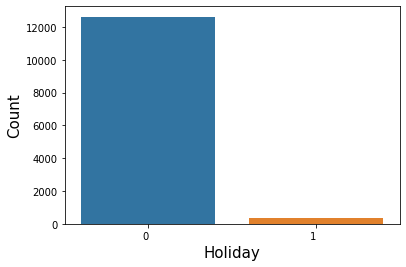

In [24]:
sns.countplot(x = 'holiday', data = df_train)
plt.xticks(fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Holiday', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        98% bookings are done on non-holidays.

### Relation Between Working Day and Count

Text(0, 0.5, 'Count')

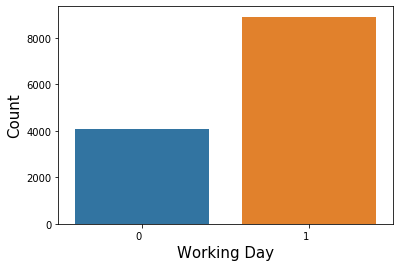

In [25]:
sns.countplot(x = 'workingday', data = df_train)
plt.xticks(fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Working Day', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        69% bookings are done on working days.

### Relation Between Weather and Count

Text(0, 0.5, 'Count')

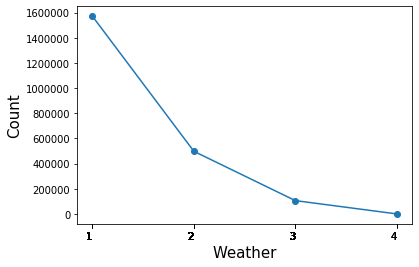

In [26]:
df_train.groupby('weather')['count'].sum().plot(marker = 'o')
plt.xticks(df_train.weather, fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Weather', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        72% bookings are done in weather 1.

        95% bookings are done in weathers 1 and 2.

### Relation Between Actual Temperature and Count

Text(0, 0.5, 'Count')

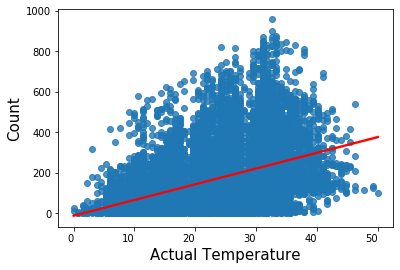

In [27]:
sns.regplot(x = df_train['atemp'], y = df_train['count'], line_kws = {'color': 'red'})
plt.xticks(fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Actual Temperature', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        Bookings are increasing with the increase in actual temperature.

### Relation Between Humidity and Count

Text(0, 0.5, 'Count')

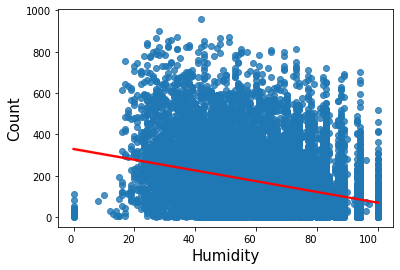

In [28]:
sns.regplot(x = df_train['humidity'], y = df_train['count'], line_kws = {'color': 'red'})
plt.xticks(fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Humidity', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        Bookings are decreasing with the increase in humidity.

### Relation Between Wind Speed and Count

Text(0, 0.5, 'Count')

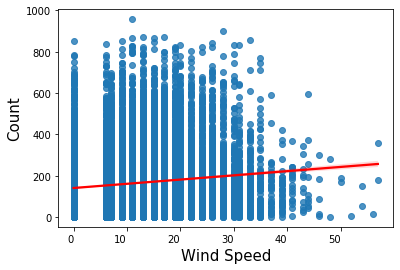

In [29]:
sns.regplot(x = df_train['windspeed'], y = df_train['count'], line_kws = {'color': 'red'})
plt.xticks(fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Wind Speed', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        Bookings are slightly increasing with the increase in wind speed.

### Relation Between Year and Count

Text(0, 0.5, 'Count')

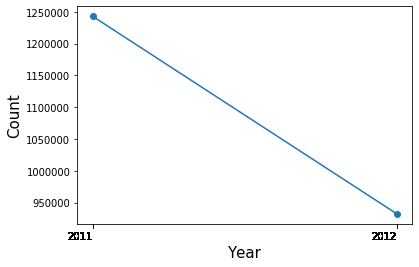

In [30]:
df_train.groupby('year')['count'].sum().plot(marker = 'o')
plt.xticks(df_train.year, fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        57% bookings are done in 2011.
        
        This data is not that valuable as we don't have the complete 2012 data with us. It is just upto June 2012.
        
        However we can compare the first six months of these two years.

### Relation Between the First 6 Months of Each Year with Count

Text(0, 0.5, 'Count')

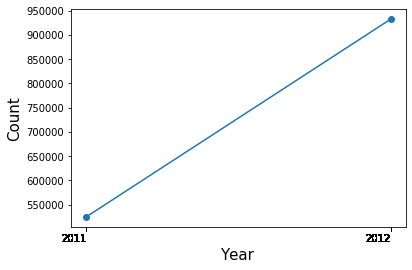

In [31]:
new_df = df_train[df_train['month'] < 7]
new_df.groupby('year')['count'].sum().plot(marker = 'o')
plt.xticks(new_df.year, fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        64% bookings are done in the first 6 months of 2012.

### Relation Between Month and Count

Text(0, 0.5, 'Count')

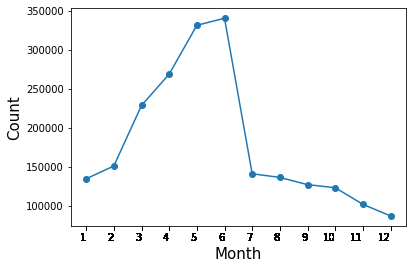

In [32]:
df_train.groupby('month')['count'].sum().plot(marker = 'o')
plt.xticks(df_train.month, fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        16% bookings are done in June.
        
        67% bookings are done during January to June.
        
        54% bookings are done during March to June.

### Relation Between Week and Count

Text(0, 0.5, 'Count')

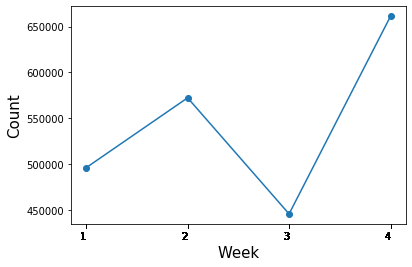

In [33]:
df_train.groupby('week')['count'].sum().plot(marker = 'o')
plt.xticks(df_train.week, fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Week', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        30% bookings are done in the last week of a month.
        
        51% bookings are done in second half of the month.

### Relation Between Hour and Count

Text(0, 0.5, 'Count')

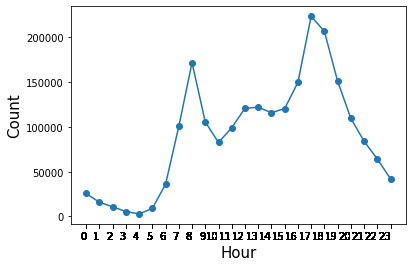

In [34]:
df_train.groupby('hour')['count'].sum().plot(marker = 'o')
plt.xticks(df_train.hour, fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Hour', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        55% bookings are done in between 12 noon to 8 pm.

        74% bookings are done in between 8 am to 8 pm.

### Checking Outliers in Actual Temperature in Train and Test Data

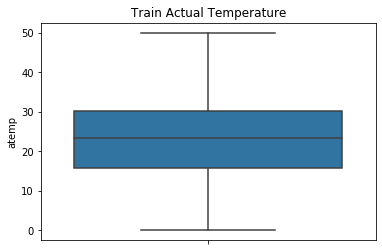

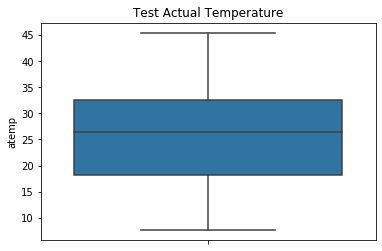

In [21]:
sns.boxplot(y = df_train['atemp'])
plt.title('Train Actual Temperature')
plt.show()
sns.boxplot(y = df_test['atemp'])
plt.title('Test Actual Temperature')
plt.show()

### Checking Outliers in Humidity in Train and Test Data

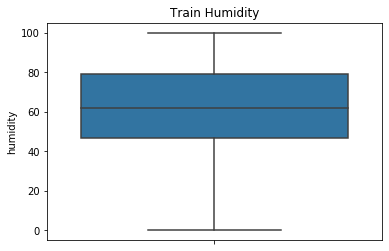

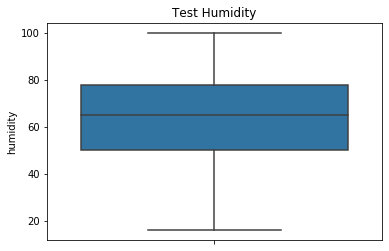

In [22]:
sns.boxplot(y = df_train['humidity'])
plt.title('Train Humidity')
plt.show()
sns.boxplot(y = df_test['humidity'])
plt.title('Test Humidity')
plt.show()

### Checking Outliers in Wind Speed in Train and Test Data

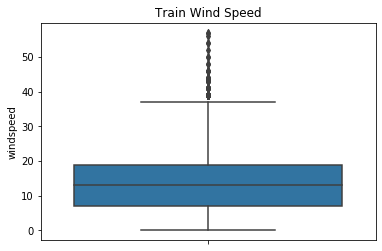

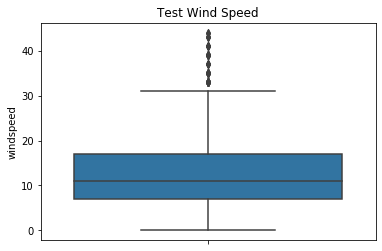

In [23]:
sns.boxplot(y = df_train['windspeed'])
plt.title('Train Wind Speed')
plt.show()
sns.boxplot(y = df_test['windspeed'])
plt.title('Test Wind Speed')
plt.show()

### Analysing the Outliers in Wind Speed

In [33]:
ctr_train = 0
ctr_test = 0
for i in df_train['windspeed']:
    if i > (df_train['windspeed'].mean() + (2 * df_train['windspeed'].std())):
        ctr_train = ctr_train + 1
for j in df_test['windspeed']:
    if j > (df_test['windspeed'].mean() + (2 * df_test['windspeed'].std())):
        ctr_test = ctr_test + 1
print('Outliers in Train Wind Speed :', ctr_train)
print('Outliers in Test Wind Speed :', ctr_test)

Outliers in Train Wind Speed : 550
Outliers in Test Wind Speed : 163


        550 and 163 are significant figures which are almost 4% and 3% of the respective data sets.
        
        These much data cannot be outliers.
        
        And moreover there is thunderstorm in weather. So some genuine high windspeed will be there.

### Checking Outliers in Count in Train Data

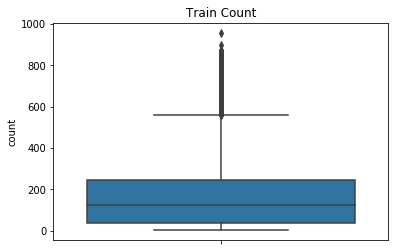

In [34]:
sns.boxplot(y = df_train['count'])
plt.title('Train Count')
plt.show()

### Analysing the Outliers in Count

In [35]:
ctr_train = 0
for i in df_train['count']:
    if i > (df_train['count'].mean() + (2 * df_train['count'].std())):
        ctr_train = ctr_train + 1
print('Outliers in Train Count :', ctr_train)

Outliers in Train Count : 707


        707 is a significant figure which is 5% of the data set and this much data cannot be outliers.

### Actual Temperature Distribution

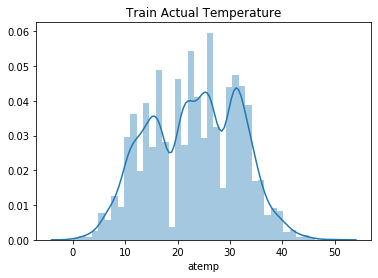

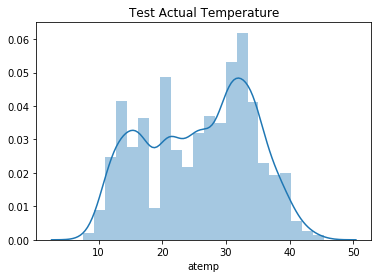

In [38]:
sns.distplot(df_train['atemp'])
plt.title('Train Actual Temperature')
plt.show()
sns.distplot(df_test['atemp'])
plt.title('Test Actual Temperature')
plt.show()

### Humidity Distribution

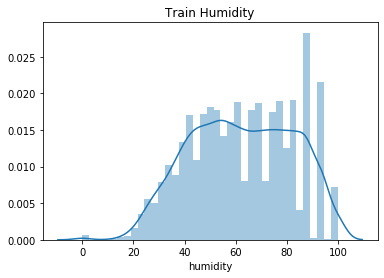

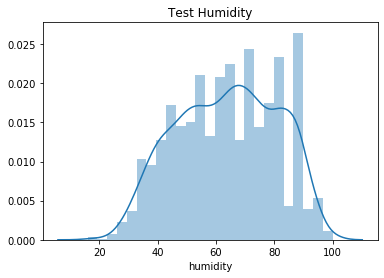

In [39]:
sns.distplot(df_train['humidity'])
plt.title('Train Humidity')
plt.show()
sns.distplot(df_test['humidity'])
plt.title('Test Humidity')
plt.show()

### Wind Speed Distribution

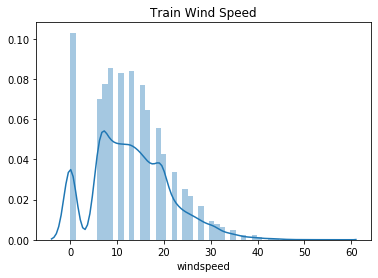

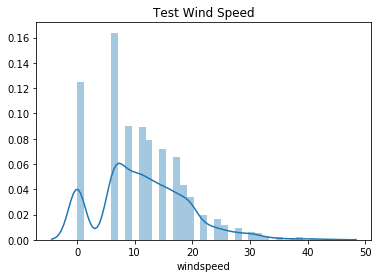

In [40]:
sns.distplot(df_train['windspeed'])
plt.title('Train Wind Speed')
plt.show()
sns.distplot(df_test['windspeed'])
plt.title('Test Wind Speed')
plt.show()

### Transforming Wind Speed

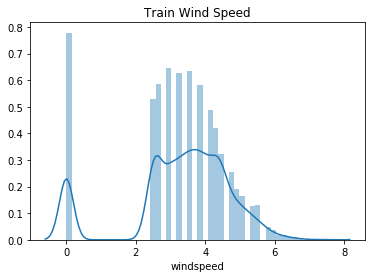

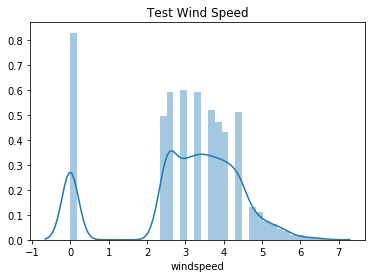

In [41]:
df_train['windspeed'] = np.sqrt(df_train['windspeed'])
df_test['windspeed'] = np.sqrt(df_test['windspeed'])
sns.distplot(df_train['windspeed'])
plt.title('Train Wind Speed')
plt.show()
sns.distplot(df_test['windspeed'])
plt.title('Test Wind Speed')
plt.show()

### Count Distribution

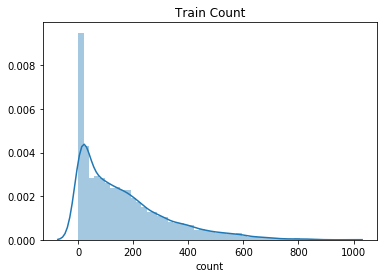

In [42]:
sns.distplot(df_train['count'])
plt.title('Train Count')
plt.show()

### Transforming Count

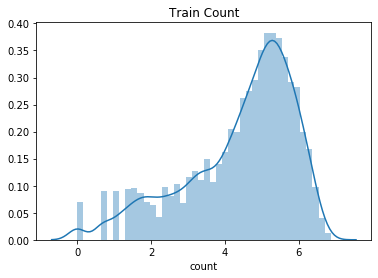

In [43]:
df_train['count'] = np.log(df_train['count'])
sns.distplot(df_train['count'])
plt.title('Train Count')
plt.show()

### Scaling Data Sets

In [44]:
df_train_scaled = df_train[['atemp', 'humidity', 'windspeed']]
df_train_scaled = StandardScaler().fit_transform(df_train_scaled)
df_train_scaled = pd.DataFrame(df_train_scaled, columns = ['atemp', 'humidity', 'windspeed'])
df_test_scaled = df_test[['atemp', 'humidity', 'windspeed']]
df_test_scaled = StandardScaler().fit_transform(df_test_scaled)
df_test_scaled = pd.DataFrame(df_test_scaled, columns = ['atemp', 'humidity', 'windspeed'])

### Replacing Original Columns by Scaled Columns

In [45]:
df_train = df_train.drop(['atemp', 'humidity', 'windspeed'], axis = 1)
df_test = df_test.drop(['atemp', 'humidity', 'windspeed'], axis = 1)
df_train = pd.concat((df_train, df_train_scaled), axis = 1)
df_test = pd.concat((df_test, df_test_scaled), axis = 1)

In [47]:
df_test.head()

,season,holiday,workingday,weather,temp,casual,registered,year,month,hour,week,atemp,humidity,windspeed
0,3,0,0,3,26.24,3,55,2012,6,1,4,0.357851,1.472355,0.550350
1,3,0,0,2,26.24,7,54,2012,6,2,4,0.357851,1.472355,-2.045224
2,3,0,0,2,26.24,3,20,2012,6,3,4,0.357851,1.472355,-2.045224
3,3,0,0,2,25.42,3,15,2012,6,4,4,0.177476,1.764464,-2.045224
4,3,0,0,1,26.24,3,7,2012,6,5,4,0.357851,1.472355,0.177538


### Dropping Temperature, Season, Year, Casual and Registered Columns

In [48]:
df_train = df_train.drop(['temp', 'season', 'year', 'casual', 'registered'], axis = 1)
df_test = df_test.drop(['temp', 'season', 'year', 'casual', 'registered'], axis = 1)

### Train Data

In [49]:
df_train.head()

,holiday,workingday,weather,count,month,hour,week,atemp,humidity,windspeed
0,0,0,1,2.772589,1,0,1,-1.019379,0.933803,-2.240587
1,0,0,1,3.688879,1,1,1,-1.108250,0.883711,-2.240587
2,0,0,1,3.465736,1,2,1,-1.108250,0.883711,-2.240587
3,0,0,1,2.564949,1,3,1,-1.019379,0.633246,-2.240587
4,0,0,1,0.000000,1,4,1,-1.019379,0.633246,-2.240587


### Test Data

In [50]:
df_test.head()

,holiday,workingday,weather,month,hour,week,atemp,humidity,windspeed
0,0,0,3,6,1,4,0.357851,1.472355,0.550350
1,0,0,2,6,2,4,0.357851,1.472355,-2.045224
2,0,0,2,6,3,4,0.357851,1.472355,-2.045224
3,0,0,2,6,4,4,0.177476,1.764464,-2.045224
4,0,0,1,6,5,4,0.357851,1.472355,0.177538


### Train, Validation and Test Data Sets

In [52]:
X = df_train.drop(['count'], axis = 1)
y = df_train['count']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 17)
X_test = df_test

### Shapes of the Data Sets

In [53]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape

((9086, 9), (3894, 9), (9086,), (3894,), (4399, 9))

### Checking the VIF

In [54]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
2,weather,5.507401
5,week,4.541742
4,hour,3.823330
3,month,3.670277
1,workingday,3.032847
7,humidity,1.404727
6,atemp,1.139684
8,windspeed,1.104076
0,holiday,1.086076


        VIF for weather is more than 5.

### Dropping Weather Column

In [55]:
X_test = X_test.drop('weather', axis = 1)
X_train = X_train.drop('weather', axis = 1)
X_val = X_val.drop('weather', axis = 1)

### Checking the VIF After Weather is Dropped

In [56]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
4,week,3.997471
2,month,3.493362
3,hour,3.382675
1,workingday,2.812703
6,humidity,1.185659
7,windspeed,1.091533
0,holiday,1.081777
5,atemp,1.081337


### Checking with Statsmodels.api

In [57]:
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train,X_train_sm)
lr = lr.fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     968.8
Date:                Thu, 24 Sep 2020   Prob (F-statistic):               0.00
Time:                        00:39:17   Log-Likelihood:                -13712.
No. Observations:                9086   AIC:                         2.744e+04
Df Residuals:                    9077   BIC:                         2.751e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2547      0.045     72.589      0.0

        p-value for week is greater than 0.05.

### Dropping Week Column

In [58]:
X_test = X_test.drop('week', axis = 1)
X_train = X_train.drop('week', axis = 1)
X_val = X_val.drop('week', axis = 1)

### Checking the VIF After Week is Dropped

In [59]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
2,month,3.006735
3,hour,2.930083
1,workingday,2.522852
5,humidity,1.182094
6,windspeed,1.090969
0,holiday,1.069516
4,atemp,1.063916


### Checking with Statsmodels.api

In [60]:
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train,X_train_sm)
lr = lr.fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     1107.
Date:                Thu, 24 Sep 2020   Prob (F-statistic):               0.00
Time:                        00:41:05   Log-Likelihood:                -13712.
No. Observations:                9086   AIC:                         2.744e+04
Df Residuals:                    9078   BIC:                         2.750e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2439      0.036     89.300      0.0

### Validation Data R2

In [61]:
X_val_sm = sm.add_constant(X_val)
y_pred_val = lr.predict(X_val_sm)
r2_score(y_val, y_pred_val)

0.423005350385414

### RMSLE for Different Algorithms

In [63]:
models = [LinearRegression(), Lasso(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), KNeighborsRegressor(), SVR(), LinearSVR(), XGBRegressor()]
model_names = ['LinearRegression', 'Lasso', 'Ridge', 'DecisionTreeRegressor', 'RandomForestRegressor', 'AdaBoostRegressor', 'GradientBoostingRegressor', 'KNeighborsRegressor', 'SVR', 'LinearSVR', 'XGBRegressor']
rmsle = []
data = {}
for model in models:
    mod = model
    mod.fit(X_train, y_train)
    y_pred_val = mod.predict(X_val)
    y_pred_val = y_pred_val.clip(0)
    rmsle.append(np.sqrt(mean_squared_log_error(y_pred_val, y_val)))
data = {'Modelling Algorithm' : model_names, 'RMSLE' : rmsle}
rmsle = pd.DataFrame(data)
rmsle.sort_values(by = 'RMSLE')

C:\Users\Brajesh\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Modelling Algorithm,RMSLE
10,XGBRegressor,0.135344
4,RandomForestRegressor,0.138895
7,KNeighborsRegressor,0.150893
6,GradientBoostingRegressor,0.151470
3,DecisionTreeRegressor,0.186923
5,AdaBoostRegressor,0.203170
8,SVR,0.227704
0,LinearRegression,0.284709
2,Ridge,0.284710
9,LinearSVR,0.294198


        XGBRegressor is the best algorithm to build the model.

### R2 for Different Algorithms

In [65]:
models = [LinearRegression(), Lasso(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), KNeighborsRegressor(), SVR(), LinearSVR(), XGBRegressor()]
model_names = ['LinearRegression', 'Lasso', 'Ridge', 'DecisionTreeRegressor', 'RandomForestRegressor', 'AdaBoostRegressor', 'GradientBoostingRegressor', 'KNeighborsRegressor', 'SVR', 'LinearSVR', 'XGBRegressor']
r2 = []
data = {}
for model in models:
    mod = model
    mod.fit(X_train, y_train)
    y_pred_val = mod.predict(X_val)
    y_pred_val = y_pred_val.clip(0)
    r2.append(r2_score(y_val, y_pred_val))
data = {'Modelling Algorithm' : model_names, 'R2' : r2}
r2 = pd.DataFrame(data)
r2.sort_values(by = 'R2', ascending = False)

C:\Users\Brajesh\anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,Modelling Algorithm,R2
10,XGBRegressor,0.909245
4,RandomForestRegressor,0.900913
7,KNeighborsRegressor,0.876725
6,GradientBoostingRegressor,0.861358
3,DecisionTreeRegressor,0.824770
5,AdaBoostRegressor,0.698874
8,SVR,0.664040
2,Ridge,0.423009
0,LinearRegression,0.423005
9,LinearSVR,0.409474


        Here also XGBRegressor came out to be the best to build the model.

### Creating Scoring Parameter

In [66]:
def scoring_parameter(actual, predict):
    actual = np.array(actual)
    predict = np.array(predict)
    predict = predict.clip(0)
    score = np.sqrt(mean_squared_log_error(predict, actual))
    return score
rmsle_score = make_scorer(scoring_parameter, greater_is_better = False)

### Tuning Hyperparameters

In [67]:
xgbr = XGBRegressor()
possible_parameter_values = {'n_estimators' : [89, 90, 91],
                             'max_depth' : [4, 5, 6],
                             'learning_rate' : [0.2, 0.3, 0.4],
                             'gamma' : [0.008, 0.009, 0.01],
                             'reg_alpha' : [0.005, 0.006, 0.007]}
xgbr_grid_search_cv = GridSearchCV(estimator = xgbr, param_grid = possible_parameter_values, cv = 10, scoring = rmsle_score)
xgbr_grid_search_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parame

### Best Parameters

In [68]:
xgbr_grid_search_cv.best_params_

{'gamma': 0.009,
 'learning_rate': 0.3,
 'max_depth': 5,
 'n_estimators': 90,
 'reg_alpha': 0.006}

### Checking the Model

In [69]:
xgbr = XGBRegressor(n_estimators = 90, max_depth = 5, learning_rate = 0.3, gamma = 0.009, reg_alpha = 0.006)
xgbr.fit(X_train, y_train)
y_pred_val = xgbr.predict(X_val)
y_pred_val = y_pred_val.clip(0)
y_pred_val = np.exp(y_pred_val)
y_val = np.exp(y_val)

### RMSLE

In [71]:
np.sqrt(mean_squared_log_error(y_pred_val, y_val))

0.4151625668923276

### Final Model and Prediction

In [72]:
xgbr = XGBRegressor(n_estimators = 90, max_depth = 5, learning_rate = 0.3, gamma = 0.009, reg_alpha = 0.006)
xgbr.fit(X_train, y_train)
y_pred_test = xgbr.predict(X_test)
y_pred_test = y_pred_test.clip(0)
y_pred_test = np.exp(y_pred_test)
y_pred_test = pd.DataFrame(y_pred_test, columns = ['Predicted Counts'])
y_pred_test = y_pred_test.round(decimals = 0)
y_pred_test['Predicted Counts'] = y_pred_test['Predicted Counts'].astype('float').astype(int)
y_pred_test.head()

,Predicted Counts
0,56
1,60
2,27
3,10
4,8


### Exporting Predictions to CSV

In [73]:
y_pred_test.to_csv('Prediction.csv')